# Transfer learning

In [7]:
# Prepare data

import zipfile
import urllib.request
from os.path import exists

if (not exists("./datasets/10_food_classes_10_percent.zip")):
    print("Downloading archive...")
    urllib.request.urlretrieve("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip", "./datasets/10_food_classes_10_percent.zip")
else:
    print("Archive already downloaded, unzipping...")

zip_ref = zipfile.ZipFile("datasets/10_food_classes_10_percent.zip")
zip_ref.extractall("./datasets")
zip_ref.close()

In [9]:
# Create loaders

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "datasets/10_food_classes_10_percent/train/"
test_dir = "datasets/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical",
                                                          shuffle=True)

test_data_10_percent = train_datagen.flow_from_directory(test_dir,
                                                          target_size=IMG_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical",
                                                          shuffle=True)
                                                          

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Callbacks

Callbacks are a tool which can add functionality to models during training, evaluation or inference.

Some popular ones:

* TensorBoard
* Model checkpoint
* Early stopping

In [24]:
# Create tensorboard callback

import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    
    return tensorboard_callback


## Create models with TensorFlow Hub

In [10]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [11]:
# Dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [20]:
def create_model(model_url, num_classes=10):
    """
    Takes a TF hub model and builds a sequential model with it
    """

    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name="feature_extractor_layer",
                                             input_shape=IMG_SHAPE+(3,)
                                            )
    
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
    
    return model
    

In [21]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [22]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
# Compile resnet model

resnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [25]:
resnet_history = resnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, validation_steps=len(test_data_10_percent), callbacks=[create_tensorboard_callback("logs", "resnet")])

Saving TensorBoard log files to: logs/resnet/20220906-120816
Epoch 1/5
24/24 [==============================] - 93s 4s/step - loss: 1.9359 - accuracy: 0.3560 - val_loss: 1.2788 - val_accuracy: 0.5876
Epoch 2/5
24/24 [==============================] - 89s 4s/step - loss: 0.9118 - accuracy: 0.7333 - val_loss: 0.8786 - val_accuracy: 0.7164
Epoch 3/5
24/24 [==============================] - 84s 4s/step - loss: 0.6257 - accuracy: 0.8213 - val_loss: 0.7804 - val_accuracy: 0.7424
Epoch 4/5
24/24 [==============================] - 82s 4s/step - loss: 0.4803 - accuracy: 0.8747 - val_loss: 0.7173 - val_accuracy: 0.7660
Epoch 5/5
24/24 [==============================] - 83s 4s/step - loss: 0.3788 - accuracy: 0.9107 - val_loss: 0.6892 - val_accuracy: 0.7760


In [26]:
resnet_model.evaluate(test_data_10_percent)

79/79 [==============================] - 75s 952ms/step - loss: 0.6892 - accuracy: 0.7760


[0.6891564726829529, 0.7760000228881836]

Try efficientnet now

In [27]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [28]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [29]:
efficientnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [30]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent), validation_data=test_data_10_percent, validation_steps=len(test_data_10_percent), callbacks=[create_tensorboard_callback("logs", "efficientnet")])

Saving TensorBoard log files to: logs/efficientnet/20220906-123510
Epoch 1/5
24/24 [==============================] - 61s 2s/step - loss: 1.8987 - accuracy: 0.4027 - val_loss: 1.3257 - val_accuracy: 0.7132
Epoch 2/5
24/24 [==============================] - 51s 2s/step - loss: 1.0762 - accuracy: 0.7760 - val_loss: 0.8790 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 51s 2s/step - loss: 0.7664 - accuracy: 0.8413 - val_loss: 0.6987 - val_accuracy: 0.8528
Epoch 4/5
24/24 [==============================] - 52s 2s/step - loss: 0.6093 - accuracy: 0.8600 - val_loss: 0.6081 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 52s 2s/step - loss: 0.5142 - accuracy: 0.8880 - val_loss: 0.5557 - val_accuracy: 0.8680


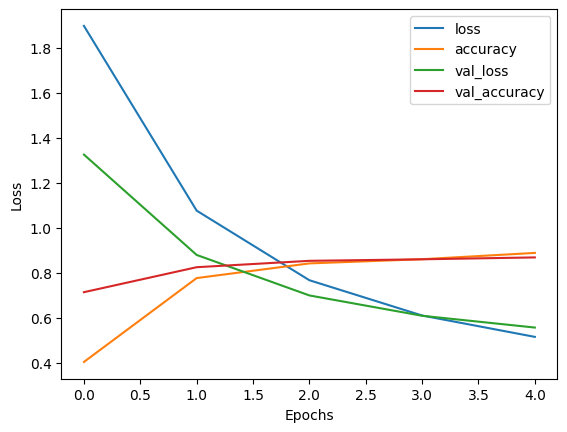

In [31]:
from plot import plot_loss_curve

plot_loss_curve(efficientnet_history)